[View this post as a Jupyter Notebook](http://nbviewer.jupyter.org/github/cgranade/cgranade.github.io/blob/master/_posts/2016-10-07-rb-multiexponential.ipynb)

## Introduction ##

Randomized benchmarking (RB) is a useful tool for characterizing quantum information processing systems, and has seen a range of different extensions over the past few years. In addition to being *useful*, though, RB presents an interesting statistical problem: how should one infer the parameters of interest from RB data? Traditionally, this is done by thinking of data analysis in terms of "fitting" a curve, but this puts severe constraints on the kinds of experiments that can be performed.

In particular, most commonly-available fitting routines work based on least-squares estimation, and hence assume that measurements follow a "true" signal plus Gaussian noise. Justifying this assumption requires large amounts of experimental data, motivating a more rigorous statistical analysis. Using Bayesian inference allows for overcoming this challenge, while also providing a characterization of one's uncertianty and allowing for adaptivity. A ready-to-use implementation of Bayesian inference for RB is provided along with our [**QInfer** software package](https://arxiv.org/abs/1610.00336), providing a useful alternative to traditional fitting.

This is even more critical for the recent extensions of RB, in that the models describing these extensions often require 
"fitting" to multiple exponential decays. Taking the Bayesian perspective allows us to more easily break the approximate degeneracy in multiexponential models, either by using prior information or experimental variety. In this post, we explain how to learn multiexponential models, using *dihedral RB* as an example. The single-qubit version of this protocol was recently proposed by [Dugas *et al.* 10/brjj](https://dx.doi.org/10/brjj) to allow for learning the fidelity of gates outside the Clifford group, and extends the RB model to include two exponential decays. Though for the sake of simplicity, we don't consider it here, the same ideas apply to the multi-qubit version of [Cross *et al.* 10/brjk](https://dx.doi.org/10/brjk). In this post, I'll step through in detail (possibly annoyingly so) how to implement and use a **QInfer** model for dihedral RB, stopping at times along the way to explain some nice techniques for scientific computing in Python. I'll assume basic familiarity with Python and with randomized benchmarking.

## Python Preamble ##

We start by turning off warnings in this post. While I don't recommend doing so in practice, there's a few superfulous warnings (mainly raised in plotting) that will be distracting from the main point of the post.

In [1]:
import warnings
warnings.simplefilter('ignore')

Next, we use the ``division`` and ``print_function`` features to make this post more compatible between Python 2 and 3. We'll also enable inline plotting so that our figures appear nicely in the post itself, and will set the DPI for inline figures high enough to be readable on the web or in print.

In [2]:
from __future__ import division, print_function
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 150}

This done, we'll import the libraries we need. We'll mainly rely on [QInfer](http://qinfer.org/) and [QuTiP](http://qutip.org/), but we'll also use Matplotlib, Mpltools and Seaborn for plotting support.

In [3]:
import numpy as np
import pandas as pd
from itertools import product

In [4]:
import matplotlib.pyplot as plt
import seaborn as sbs
import mpltools.special
try:
    plt.style.use('ggplot-rq')
except:
    pass

In [5]:
import qinfer as qi
import qutip as qt

## Defining a Model and a Prior ##

With all of the boring distractions out of the way, we can now focus on defining a model for dihedral RB. As noted by [Dugas *et al.* 10/brjj](https://dx.doi.org/10/brjj), similar to the standard randomized benchmarking model, the probability of getting a "+1" measurement in a dihedral RB experiment is given by
\begin{align*}
    \Pr(+1 | m, b_1, b_2) & = (-1)^{b_1} A p_0^m + \left((-1)^{b_1 + b_2} B_1 + (-1)^{b_2} B_2\right) p_1^m + C,
\end{align*}
where $m$ is the length of the sequence being measured, $b_1, b_2 \in \{0, 1\}$ are bits describing the final measurement, and where $A, B_1, B_2, C$ are the state preparation and measurement (SPAM) constants analgous to $A$ and $B$ in traditional RB.
Since this specifies the probability of each possible observation, we call the above function the *likelihood functuion* for dihedral RB.

Having specified the likelihood, we can think of it as specifying a six-dimensional model $\vec{x} = (p_0, p_1, A, B_1, B_2, C)$ with three experiment parameters $\vec{e} = (m, b_1, b_2)$. In particular, measurments in this model consist of:

- Picking a dihedral gate sequence of length $m$,
- Applying the sequence to a fixed initial state $\rho$,
- Applying the inverse of the sequence, followed by $\sigma_x^{b_1} \sigma_z^{b_2}$,
- Performing a fixed measurement effect $E$ on the final state.

We can encode this in **QInfer** as a two-outcome model, with the outcomes 0 and 1 corresponding to observing $\mathbb{1} - E$ and $E$ (respectively) in the final step of each measurement. To do so, we need to provide some metadata about the model (how many outcomes, how many model parameters, etc.), as well as two methods which specify what model parameters are valid, and what the likelihood function is. We provide each of these by making a new *class* with *methods* and *properties* corresponding to each part of our model.

To explain each piece of our new dihedral RB model at a time, we'll use a [stupid trick](http://www.cgranade.com/blog/2016/10/07/documenting-long-classes-jupyter-notebook.html) to break up the class definition.
Ordinarily, we would have to define the class all at once, which makes it harder to walk through the definition piece-by-piece. By making a class inherit from itself, however, we can circumvent this and explain each part of the class.
To be perfectly clear, this trick should **never** be used in practice, as it results in some very subtle bugs and much less organized code. Rather, one should always define the entire class, and use a hierarchy of classes to break up definitions if needed. That said, our trick helps us at the moment, so we'll do something massively inadvisable and use it anyway. If you use the trick presented here in your own project, please don't say I didn't warn you.

With that caveat aside, we'll start by defining the metadata needed to tell **QInfer** what model parameters, experiment parameters and outcomes our new model will support.

In [6]:
class DihedralRBModel(qi.FiniteOutcomeModel):    
    @property
    def n_modelparams(self):
        return 6
    
    @property
    def modelparam_names(self):
        return ['p_0', 'p_1', 'A', 'B_1', 'B_2', 'C']        
    
    @property
    def expparams_dtype(self):
        return [('m', 'uint'), ('b_1', bool), ('b_2', bool)]
    
    @property
    def is_n_outcomes_constant(self):
        return True

    def n_outcomes(self, expparams):
        return 2

By inheriting from ``FiniteOutcomeModel``, we tell QInfer that our model has a finite number of outcomes that are each labeled by nonnegative integers. In particular, by specifying ``is_n_outcomes_constant`` and ``n_outcomes``, we tell QInfer that there are always two outcomes. This is not really a limitation, though, since we can use ``qi.BinomialModel`` to easily extend our two-outcome definition to include repeated measurements of the same $m$, $b_1$ and $b_2$.

Next, we'll use our trick to add a method which specifies which values of our model parameters $\vec{x}$ are allowable for dihedral RB. If you want to use this class in practice, just copy and paste the new method below into the definition above instead of using the trick, making one big class that has all of the metadata along with the next two methods.

In [7]:
class DihedralRBModel(DihedralRBModel):    
    def are_models_valid(self, modelparams):
        p_0, p_1, A, B_1, B_2, C = modelparams.T
        return np.all(sum((
            [
                s_1 * A + s_1 * s_2 * B_1 + s_2 * B_2 + C <= 1,
                s_1 * A + s_1 * s_2 * B_1 + s_2 * B_2 + C >= 0,
                    
                          s_1 * s_2 * B_1 + s_2 * B_2 + C <= 1,
                          s_1 * s_2 * B_1 + s_2 * B_2 + C >= 0,
                
                s_1 * A                               + C <= 1,
                s_1 * A                               + C >= 0,
            ]
            for s_1, s_2 in product([-1, +1], repeat=2)
        ), []) + [
                p_0 <= 1,
                p_0 >= 0,
                        
                p_1 <= 1,
                p_1 >= 0
            ],
        axis=0)

There's a fair bit going on here, so let's break it down a bit. First, note that we've used destructuring assignment to unpack the model parameters into convienent names. Destructuring assignment allows us to assign more than one variable at once by using an iterable collection of values. For instance:

In [8]:
zero, one, two = range(3)
print(zero)
print(one)
print(two)

0
1
2


In the context of NumPy arrays, we need to know that arrays iterate over their *leftmost* index. For a two dimensional array (that is, what's colloquially known as a matrix), destructing thus assigns each *row* to a different variable:

In [9]:
a, b = np.array([
    [10, 11],
    [12, 13]
])
print(a)
print(b)

[10 11]
[12 13]


In the context of ``are_models_valid``, **QInfer** will call this method of our model with the argument ``modelparams`` being an array of shape ``(n_models, 6)``, where ``n_models`` is the number of models that **QInfer** is considering, and where 6 is derived from our earlier specification of ``n_modelparams``. That is, **QInfer** represents each model vector $\vec{x}$ as a row of a matrix $X$. We thus need to destructure the transpose $X^{\mathrm{T}}$ instead to get each model parameter into its own variable. This is especially convienent in the context of [broadcasting](http://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html), as it means that we can combine these destructured model parameters using various arithmetic operators and NumPy functions while preserving the shape.

Next, we have used ``np.all([...], axis=0)`` to test many different conditions at once. This works because ``np.all`` reduces over the specified axis (here, ``0`` specifies the leftmost/outermost index) to return an array with one less axis. For instance:

In [10]:
np.all([
    [True, False, True],
    [False, True, True],
], axis=0)

array([False, False,  True], dtype=bool)

Thus, ``np.all`` tells us that only the third "column" contains ``True`` for each row. We can then build a list of separate conditions and check each with ``np.all`` to efficiently test each model vector. To build up the list of conditions, we note that we need our likelihood to return a probability for each $b_1,b_2 \in \{0, 1\}$. We can represent this concept using a [generator comprehension](https://www.python.org/dev/peps/pep-0289/):

In [11]:
(
    [s_1, s_2] for s_1, s_2 in product([-1, +1], repeat=2)
)

<generator object <genexpr> at 0x000000000CBEC828>

For our example, this is basically a fancy way of saying something that iterates over each assignment of $b_1$ and $b_2$:

In [12]:
list(_)

[[-1, -1], [-1, 1], [1, -1], [1, 1]]

Next, we've used ``sum`` (notably *not* ``np.sum``, which acts only on arrays!) to concatenate the lists of conditions for each $b_1$ and $b_2$. This works because the builtin ``sum`` effectively just calls ``+`` a lot, which for lists gives the concatenation:

In [13]:
['a'] + ['b']

['a', 'b']

The only thing to watch out for with using ``sum`` to concatenate lists is that we need to tell it to start with the empty list ``[]``:

In [14]:
sum(([idx] * idx for idx in range(1, 4)), [])

[1, 2, 2, 3, 3, 3]

With all this out of the way, we can now much more easily see why ``are_models_valid`` works: it builds a list of conditions for each possible pair of bits, then concatenates them together, adds in a few other conditions that don't depend on the bits $b_1$ and $b_2$, then uses ``np.all`` to ensure that every condition holds. In this way, ``are_models_valid`` quickly tests that each model vector is guaranteed to return a likelihood between 0 and 1, as is required by the fact that likelihood functions describe probabilities.

With this done, we can now specify the likelihood function itself.

In [15]:
class DihedralRBModel(DihedralRBModel):    
    def likelihood(self, outcomes, modelparams, expparams):
        # The logic to count calls is defined in the superclass qi.Model,
        # which is what FiniteOutcomeModel and DihedralRBModel each
        # derive from in turn. Because of our stupid self-inheritence
        # trick, we don't use the super function built into Python
        # the "right" way; see
        #    https://docs.python.org/2/library/functions.html#super
        # for how to do things correctly.
        super(type(self), self).likelihood(
            outcomes, modelparams, expparams
        )
        
        # This indexing trick means that p_0, p_1, ... each have
        # shape (n_models, 1), making it easier to broadcast with the
        # experiment parameters below.
        p_0, p_1, A, B_1, B_2, C = (modelparams.T)[:, :, np.newaxis]
        
        m = expparams['m']
        s_1 = (-1) ** expparams['b_1']
        s_2 = (-1) ** expparams['b_2']
        
        # Allocating first serves to make sure that a shape mismatch later
        # will cause an error.
        pr1 = np.zeros((modelparams.shape[0], expparams.shape[0]))
        pr1[:, :] = (
            s_1 * A * p_0 ** m + ((s_1 * s_2) * B_1 + s_2 * B_2) * p_1 ** m + C
        )
        
        # Now we concatenate over outcomes.
        return qi.FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, 1 - pr1)

Let's break this one down a bit as well. First, we use ``super`` to ensure that **QInfer** can properly keep track of how many times the likelihood function is called--- this gives us a useful diagnostic when we're trying to figure out what sort of simulation costs we're incurring.

Next, we use the same unpacking technique, along with a *slice* using ``np.newaxis``. When used in a slice, ``newaxis`` does just what it says on the tin: it adds a new axis to an array. For instance:

In [16]:
arr = np.empty((2, 3))
print(arr.shape)
print(arr[:, :, np.newaxis].shape)

(2L, 3L)
(2L, 3L, 1L)


This is very convienent for broadcasting. In particular, **QInfer** expects that our likelihood function (at least for a two-outcome model, more on this later) to return an array $L_{jk}$, with $j$ indexing models and $k$ indexing experiments. With broadcasting, we can do this if each unpacked model parameter has shape ``(n_models, 1)``, so that the second index (of length 1) repeats over experiments. To accomplish this in a straightforward manner, we use transpose and ``newaxis`` to get an array of shape ``(6, n_models, 1)``, then unpack the leftmost index as before.

For experiment parameters, we can just pull each out by name to get an array of shape ``(n_experiments,)``. Importantly, this shape broadcasts with ``(n_models, 1)`` to give a shape ``(n_models, n_experiments)``, exactly as required. Let's see how this works in a quick example by defining two arrays of shape ``(3,)`` and ``(4,)``.

In [17]:
arr1 = np.array([1, 2, 3])
print(arr1.shape)

arr2 = np.array([10, 20, 30, 40])
print(arr2.shape)

(3L,)
(4L,)


In [18]:
print(arr1[:, np.newaxis].shape)

(3L, 1L)


Suppose we want to make a new array ``arr3`` such that ``arr3[i, j] == arr1[i] + arr2[j]`` (that is, an outer product over ``+`` instead of ``*``). We do this by adding a new axis to ``arr1`` of length 1; this will then broadcast over the index of ``arr2`` when added.

In [19]:
arr3 = arr1[:, np.newaxis] + arr2
print(arr3.shape)
print(arr3)

(3L, 4L)
[[11 21 31 41]
 [12 22 32 42]
 [13 23 33 43]]


As we can see, elements of ``arr1`` are repeated 3 times in order to make a ``(4, 3)`` shape array. Broadcasting similarly repeats ``arr2``, even though we did not explicitly add a new axis to its left, as shapes are aligned at the right when finding which indices need repeated to match shapes.

Returning to ``likelihood``, we ensure that the shape of our likelihood array is correct by pre-allocating an array ``pr1`` to hold the probabilty of getting a ``1`` outcome for each model and experiment. We then assign the actual likelihood values as computed using our unpacked and reshaped model and epxeriment parameters into a slice of ``pr1``, such that the assignment will cause an error if we make an indexing mistake, as opposed to proceeding silently with our mistake intact.

In doing so, note that our index gymnastics paid off; the final expression for ``pr1`` reads pretty much exactly like the mathematical expression we're trying to implement. Broadcasting works, is fun, and helps you write efficient code.

Anyway, with ``pr1``, we have one last step to do before returning. **QInfer** supports more than just two-outcome models, such that in general we need to care about which outcome the likelihood function is being evaluated for. This is handled by a third index, such that the likelihood function in general should return $L_{ijk}$, with $i$ indexing which outcome. Since this is redundant for two-outcome models, **QInfer** provides the ``pr0_to_likelihood_array`` function to handle two-outcome models. This takes the probability of zero, not one, so we complete our likelihood function by taking ``1 - pr0``.

Now that we have completed our model, let's go on and use it. As mentioned above, we will want to wrap our model in ``BinomialModel`` to handle the case of more than one measurement per sequence length, so let's do that now.

In [20]:
model = qi.BinomialModel(DihedralRBModel())

We can then use our new model's validity checking to define a prior that is supported only on model vectors that make sense (that is, that yield likelihoods in the range 0 to 1). This is done by the ``PostselectedDistribution`` provided with **QInfer**. Since we have more conditions than is usual, we allow for more iterations with the ``maxiters`` keyword argument.

In [21]:
prior = qi.PostselectedDistribution(qi.UniformDistribution(
    # We'll pick a prior on p₀ and p₁ consistent with
    # F approximately ≥ 0.8.
    [[0.8, 1]] * 2 +
    # We'll be as agnostic as possible with respect to
    # A, B₀, B₁ and C; most of the parameters in this
    # range will be invalid, but the posts
    [[-0.5, 0.5]] * 3 + [[-1, 1]]
), model, maxiters=10000)

Next, let's get an idea what this prior looks like. We can use Seaborn's ``PairGrid`` to plot estimated distributions from samples of the prior.

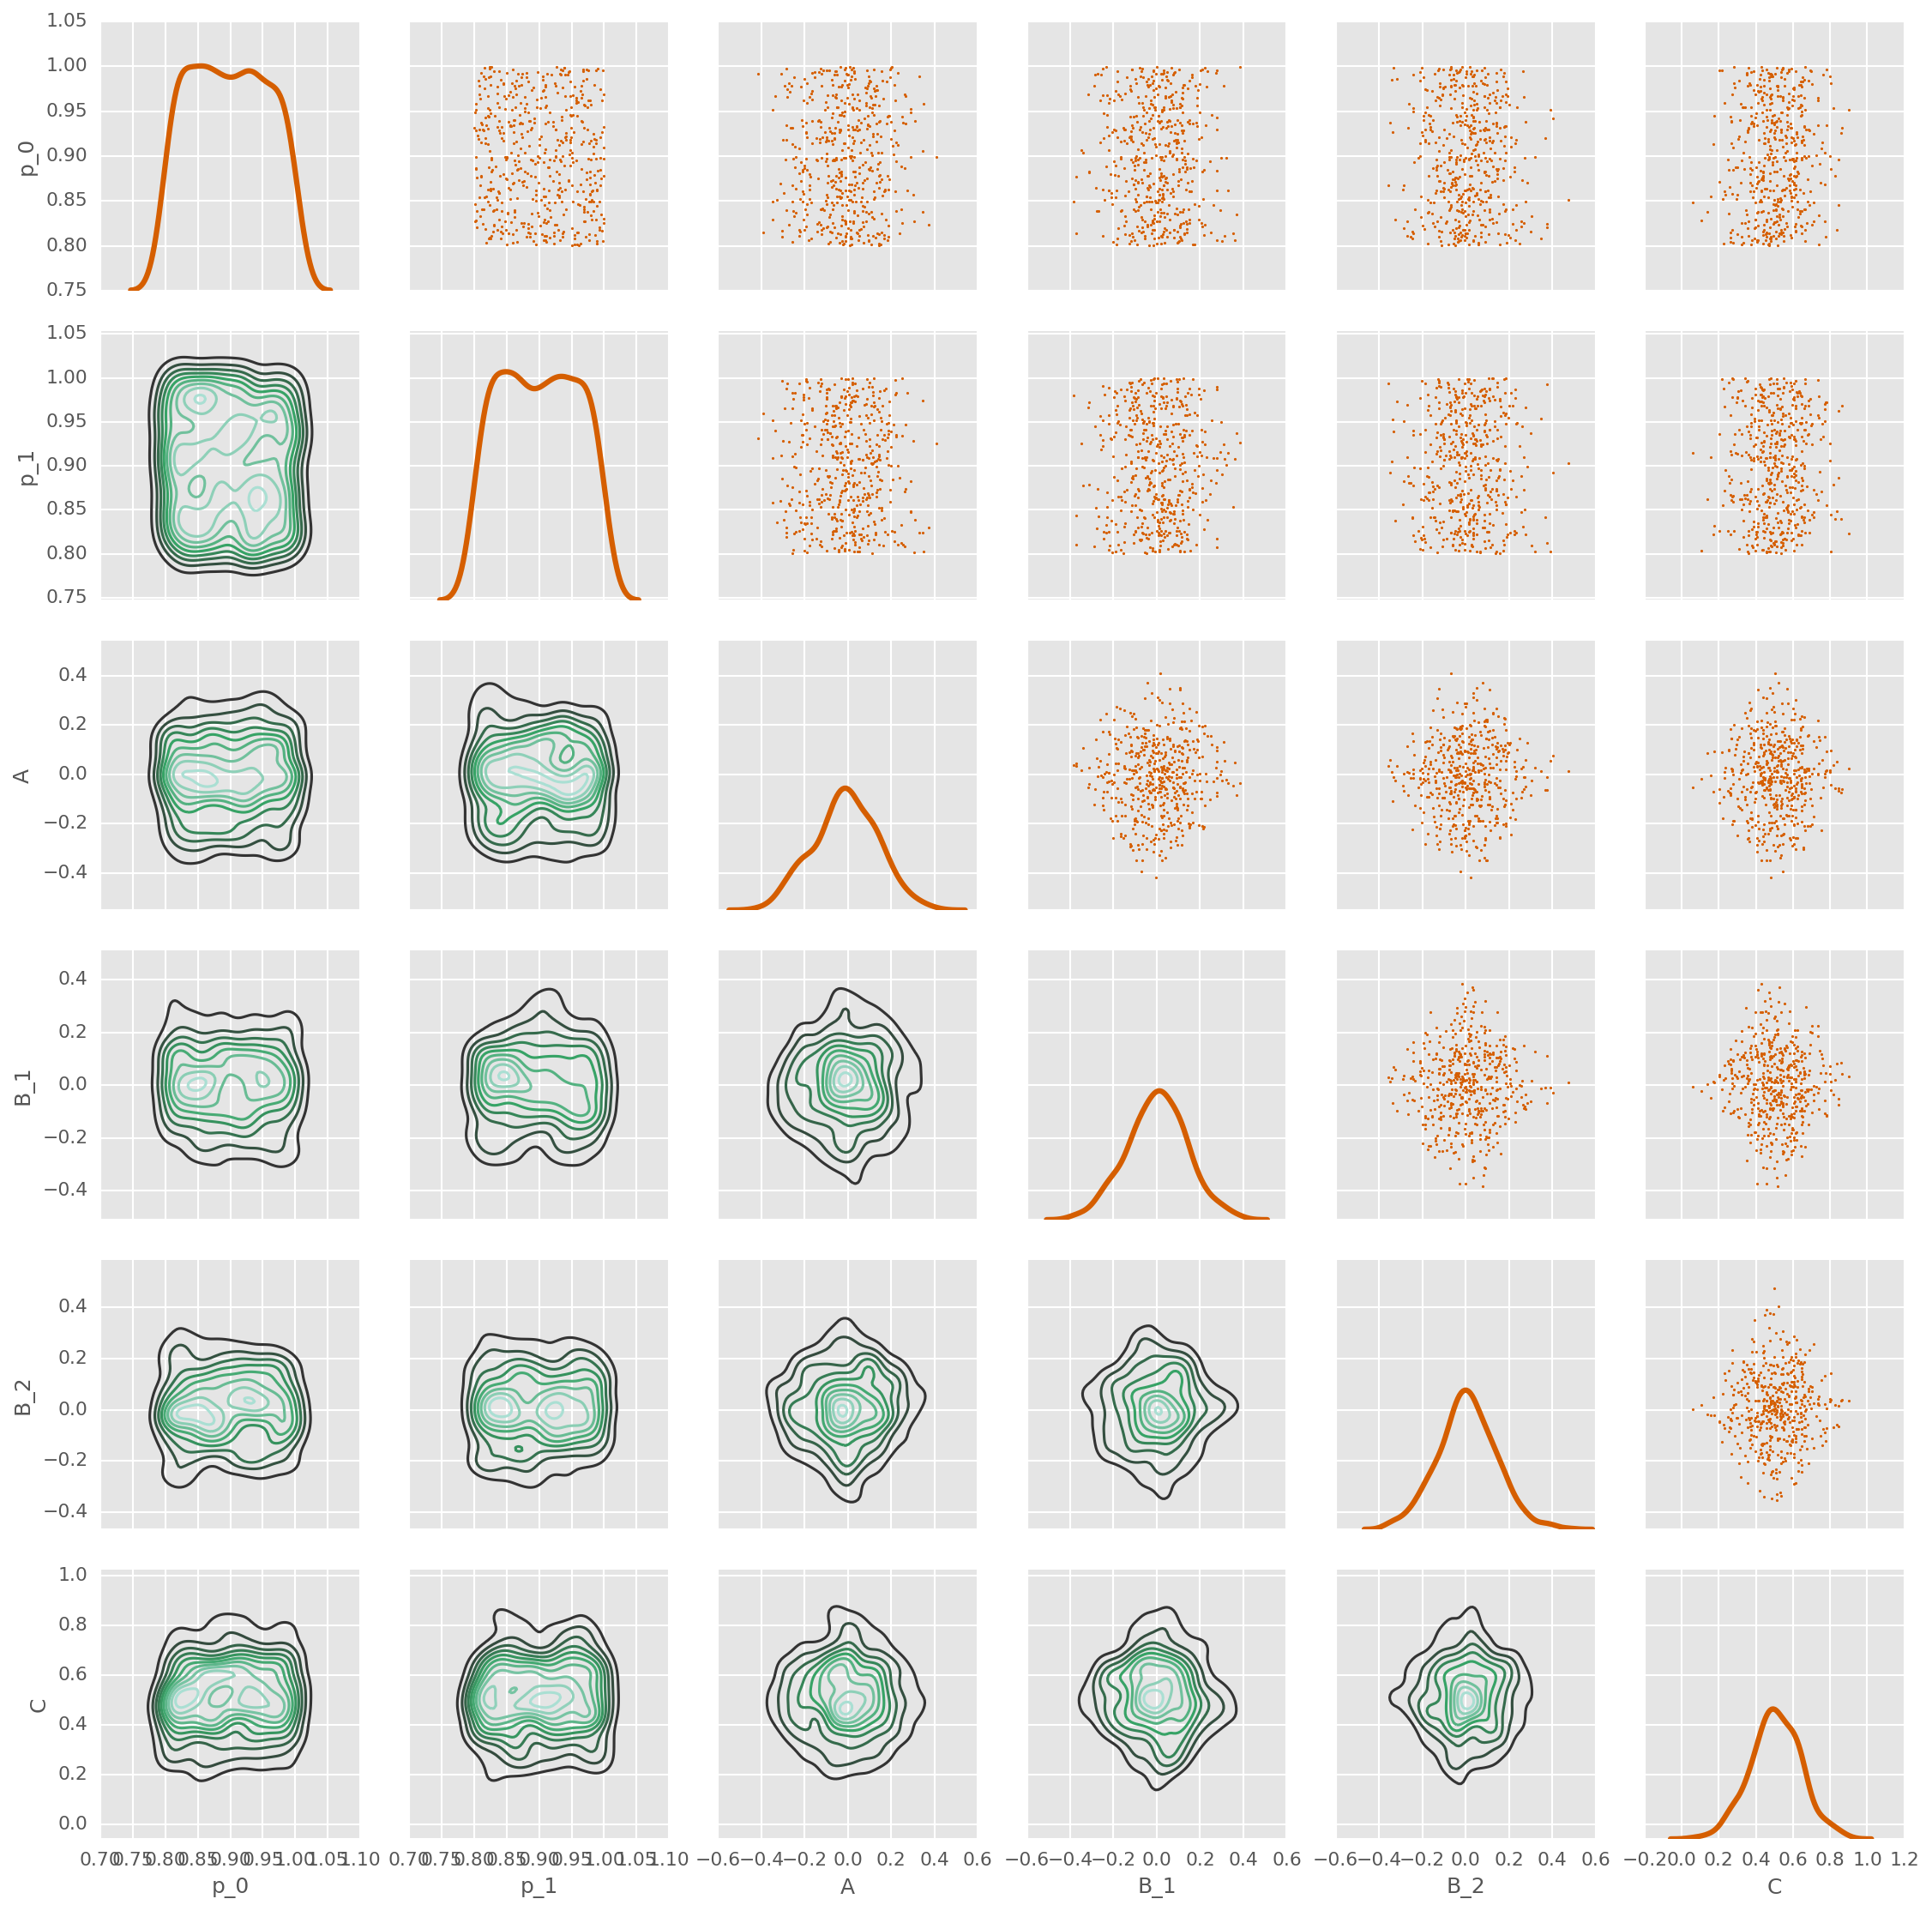

In [22]:
prior_samples = pd.DataFrame(prior.sample(n=500), columns=model.modelparam_names)
# Example from documentation at:
#     http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.PairGrid.html#seaborn.PairGrid
grid = sbs.PairGrid(prior_samples)
grid.map_upper(plt.scatter, s=1)
grid.map_lower(sbs.kdeplot, shade=False)
grid.map_diag(sbs.kdeplot, lw=3, legend=False)

Importantly, we note that the $B_1$, $B_2$ and $C$ parameters are no longer independent once we include the validity checking. We may be able to deal with this in a more elegant fashion by reparameterizing the problem, but there's no real need in this case. **QInfer** handles the correlated prior returned by ``PostselectedDistribution`` just fine, and the validity checks are quite fast.

In [23]:
%timeit prior.sample(n=10000)

1 loop, best of 3: 322 ms per loop


## Estimation with the Dihedral RB Model ##

Sampling from a prior is all well and good, but we defined our dihedral RB model so that we could learn from dihedral experiments. We start by defining a "true" set of model parameters that we'll use to generate data, and to compare our estimates to at the end. For this, we'll use QuTiP to implement the expressions given in Dugas *et al.* for a initial state and final measurement given by the magic state.

In [24]:
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()
SI, SX, SY, SZ = map(qt.to_super, [I, X, Y, Z])
error_channel = 0.98 * SI + 0.01 * SZ + 0.005 * (SY + SX)
initial_state = (I + (X + Y + Z) / np.sqrt(3)).unit()
final_meas = (I + (X + Y + Z) / np.sqrt(3)).unit()

We'll define $p_0$ and $p_1$ manually so that we don't have to define twirling in this post; for more detail, please see the [traditional RB example](https://github.com/QInfer/qinfer-examples) provided with **QInfer**.

In [25]:
p_0 = 0.97
p_1 = 0.98
A   = np.real(0.5 * (final_meas * error_channel(Z)).tr() * (initial_state * Z).tr())
B_1 = np.real(0.5 * (final_meas * error_channel(Y)).tr() * (initial_state * Y).tr())
B_2 = np.real(0.5 * (final_meas * error_channel(X)).tr() * (initial_state * X).tr())
C   = np.real(0.5 * (final_meas * error_channel(I)).tr())

We then pack these parameters into an array and check that they're valid.

In [26]:
true_model_parameters = np.array([[
    # Set p₀ and p₁ to be a channel with noise
    # that's more strong in the Z direction,
    # and that has fidelity
    # F = ½ + ⅙ (p₀ + 2 p₁) ≈ 0.9916.
    p_0, p_1,
    A, B_1, B_2, C
]])

In [27]:
assert model.are_models_valid(true_model_parameters)

Importantly, this provides a very useful guard against mistakes in our definitions--- a badly normalized initial state, for instance, may cause this validity check to fail, such that we can notice and correct the problem.

At any rate, we now create the SMC updater as usual:

In [28]:
updater = qi.SMCUpdater(model, 12000, prior)

A quick check shows that our initial uncertianty is mostly uncorrelated, such that the correlations introduced by the boundaries in our prior are relatively small.

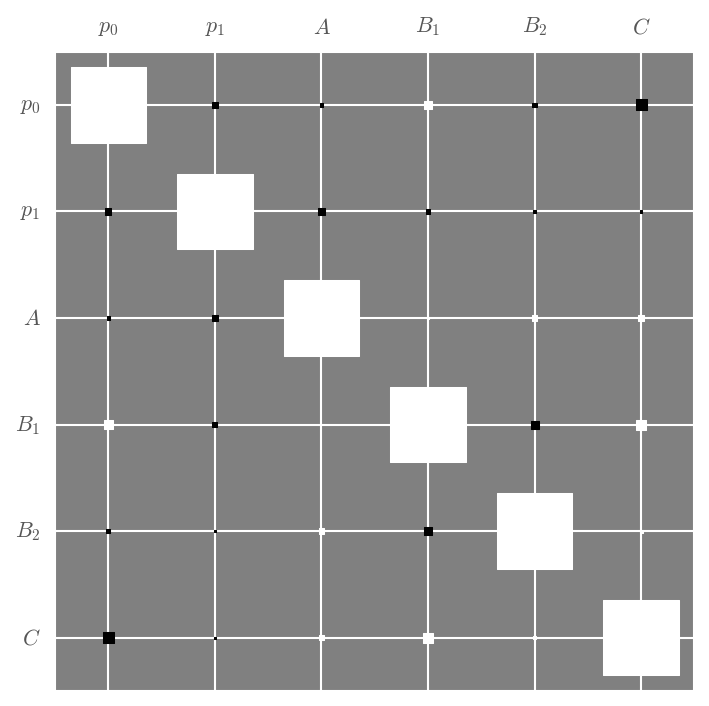

In [29]:
updater.plot_covariance(corr=True)

Next, we define a heuristic that we'll use to pick each tuple of $m$, $b_1$ and $b_2$. We'll choose $b_1$ and $b_2$ randomly for each set of sequences, and will pick $m \approx 1 / (1 - F)$, such that we choose longer sequences as necessary to refine our uncertianty in $p_0$ and $p_1$.

In [30]:
def dihedral_heuristic(updater, **kwargs):
    expparams = np.empty((1,), dtype=updater.model.expparams_dtype)
    
    for name, value in kwargs.items():
        expparams[name] = value
    
    def next_experiment():
        n_experiments_so_far = len(updater.data_record)
        p_0, p_1, A, B_1, B_2, C = updater.est_mean()
        F = 1 / 2 + (p_0 + 2 * p_1) / 6        
        
        expparams['m'] = max(2, np.floor(1 / (1 - F)))
        expparams['b_1'] = np.random.choice([True, False])
        expparams['b_2'] = np.random.choice([True, False])
        
        return expparams
        
    return next_experiment

Putting everything together, we can now run our typical updater loop.

In [31]:
heuristic = dihedral_heuristic(updater, n_meas=10)
for idx_experiment in range(1000):
    expparams = heuristic()
    datum = model.simulate_experiment(true_model_parameters, expparams)
    updater.update(datum, expparams)

Let's check and see how well we did.

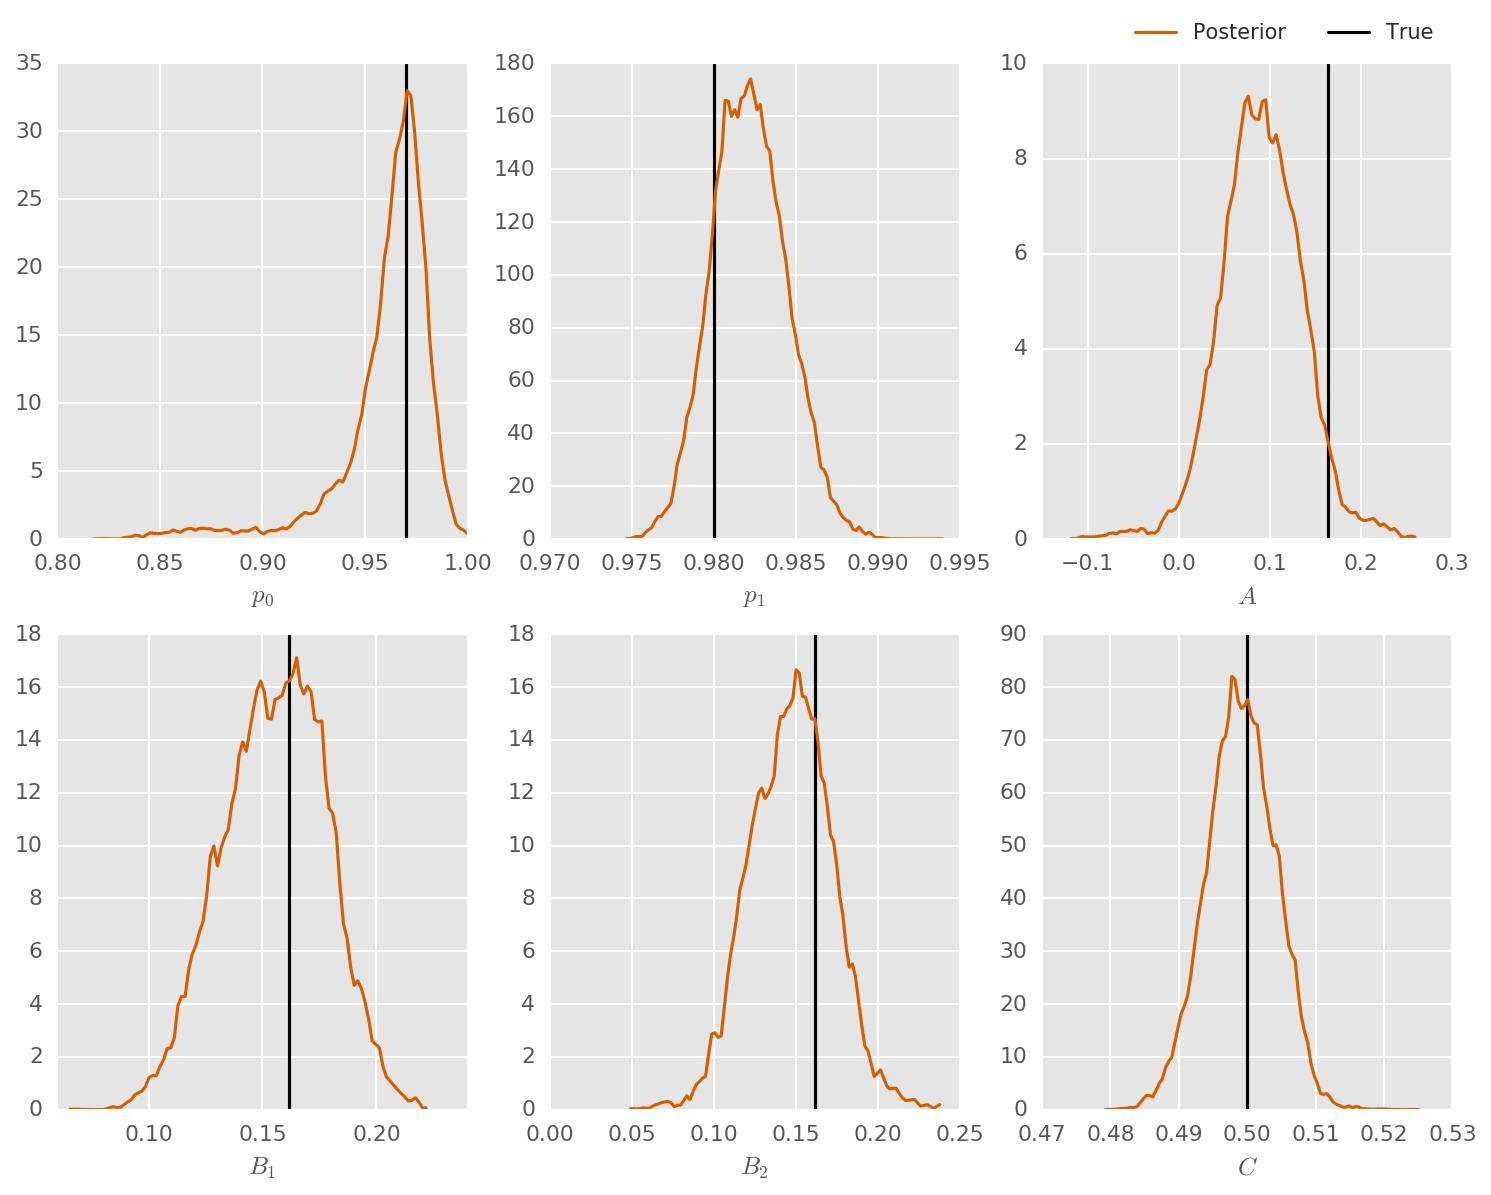

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9))
for idx, subplot_axes in enumerate(axes.flat):
    plt.sca(subplot_axes)
    updater.plot_posterior_marginal(idx_param=idx, res=100)
    ylim = plt.ylim()
    plt.vlines(true_model_parameters[0, idx], *ylim, label='True')
    plt.ylim(*ylim)
    
plt.sca(axes[0, 2])
plt.legend(['Posterior', 'True'], ncol=2, bbox_to_anchor=(1, 1.125))

The posterior covariance is much more correlated than the prior, indicating our uncertianty is being dominated by a combination of different model parameters.

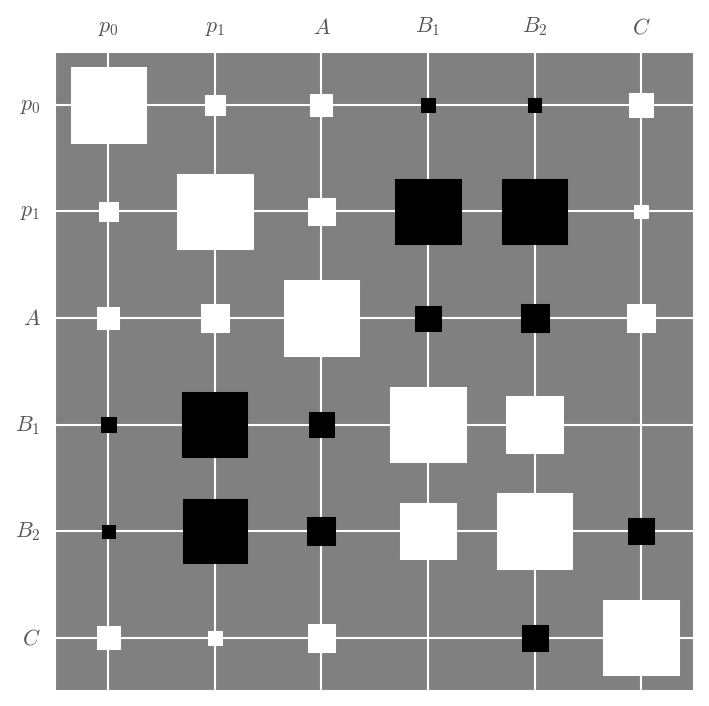

In [33]:
updater.plot_covariance(corr=True)

To investigate this further, we can take the spectrum of the covariance, and look at the ratio of the covariance explained by each eigenvector.

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 <a list of 8 Text xticklabel objects>)

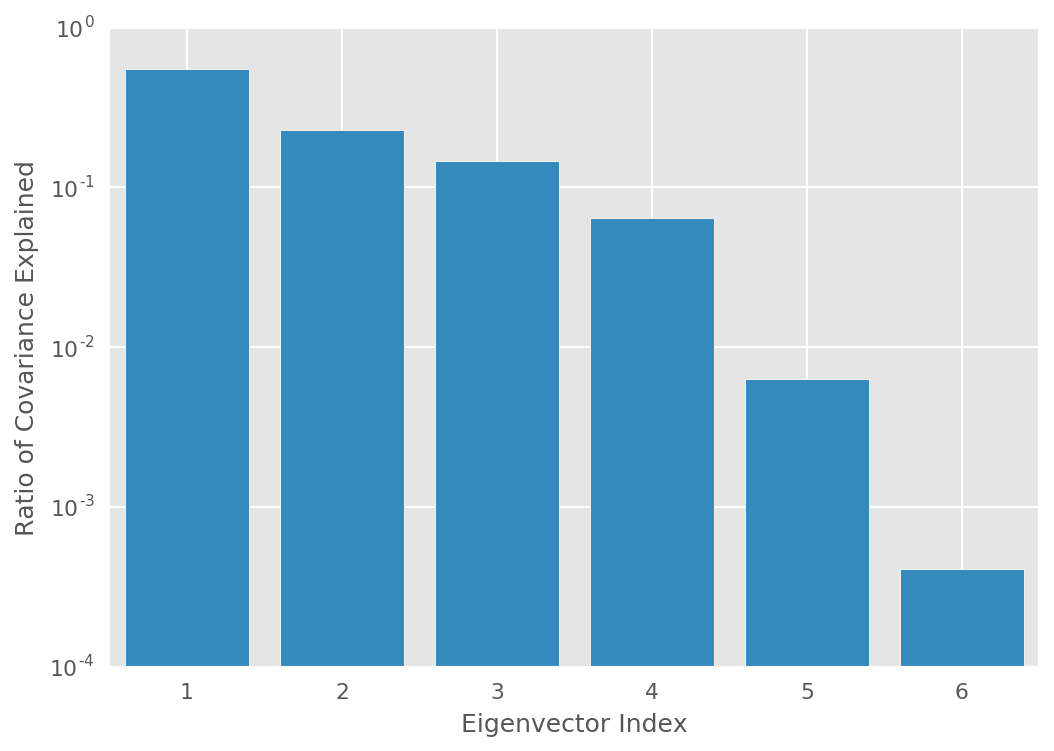

In [34]:
cov = updater.est_covariance_mtx()
evals, eigvecs = np.linalg.eigh(cov)
evals /= np.sum(evals)
plt.bar(0.6 + np.arange(6), evals[::-1])
plt.gca().set_yscale('log')
plt.xlim(0.5, 6.5)
plt.xlabel('Eigenvector Index')
plt.ylabel('Ratio of Covariance Explained')
plt.xticks()

The dominant eigenvector then tells us about what parameters we should try to learn more about to most effectively improve our final estimates.

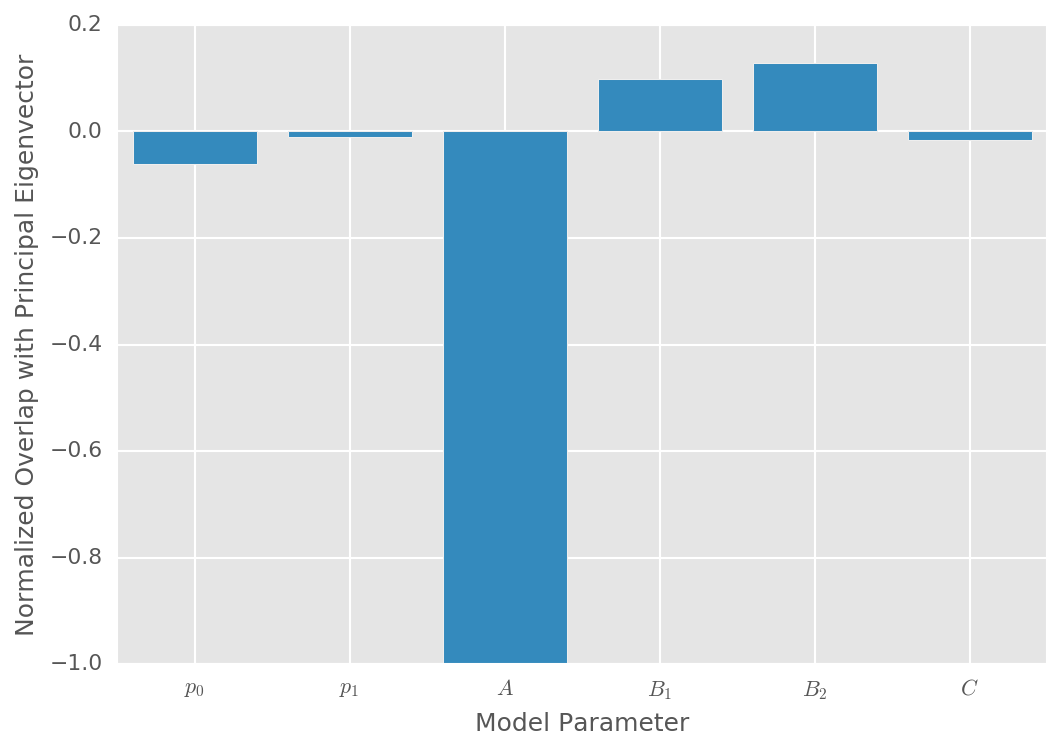

In [35]:
plt.bar(0.6 + np.arange(6), eigvecs[:, -1] / np.max(np.abs(eigvecs[:, -1])))
plt.xlim(0.5, 6.5)
plt.xticks(1 + np.arange(6), list(map("${}$".format, updater.model.modelparam_names)))
plt.xlabel('Model Parameter')
plt.ylabel('Normalized Overlap with Principal Eigenvector')

We can get a much more complete sense of our uncertianty by plotting the same slices through the posterior as we did above for the prior.

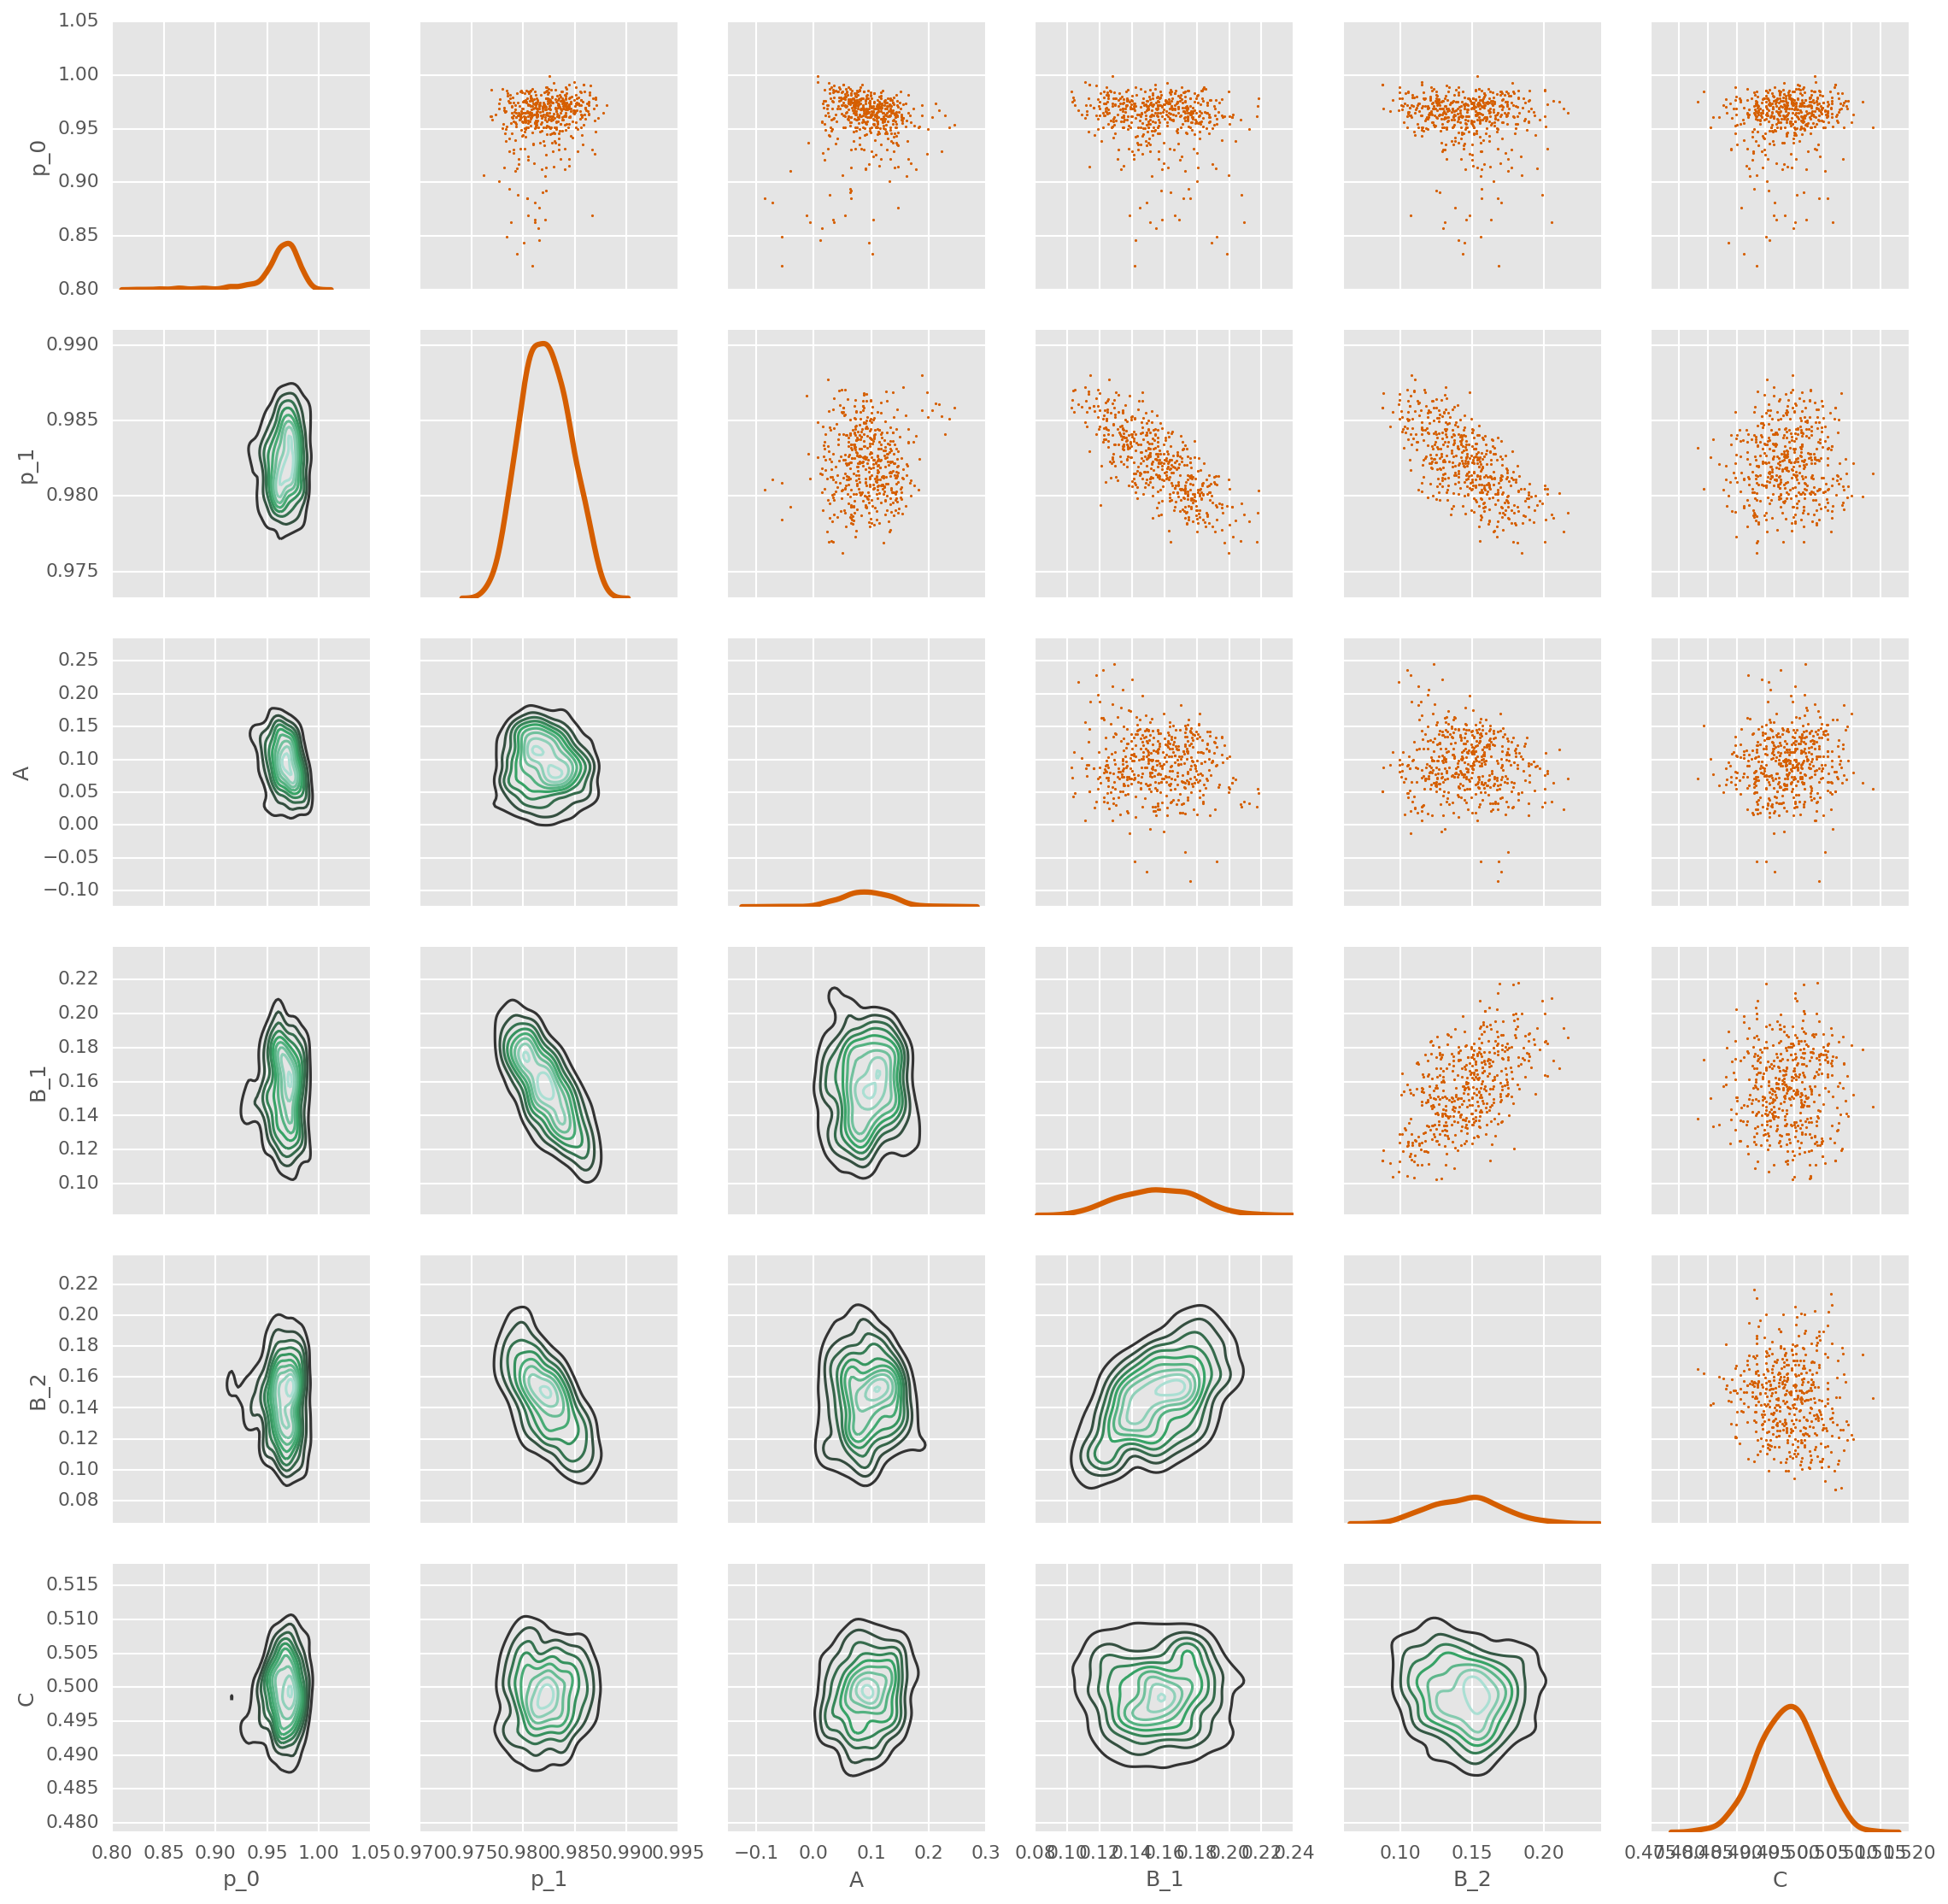

In [36]:
posterior_samples = pd.DataFrame(updater.sample(n=500), columns=model.modelparam_names)
# Example from documentation at:
#     http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.PairGrid.html#seaborn.PairGrid
grid = sbs.PairGrid(posterior_samples)
grid.map_upper(plt.scatter, s=1)
grid.map_lower(sbs.kdeplot, shade=False)
grid.map_diag(sbs.kdeplot, lw=3, legend=False)

## Epilogue ##

We finish the post by exporting it to Jekyll:

In [38]:
!jupyter nbconvert --to html --template jekyll.tpl 2016-10-07-rb-multiexponential

[NbConvertApp] Converting notebook 2016-10-07-rb-multiexponential.ipynb to html
[NbConvertApp] Writing 2689656 bytes to 2016-10-07-rb-multiexponential.html
